In [1]:
import numpy as np
from plot import plot, plot_one

n_samples = 10000
hidden_layer_dim = 10
learning_rate = 1e-4
epochs = 1001
batch_size = 100

X_np = np.random.randn(n_samples, 1) * 2
y_np = np.sin(X_np) + np.random.randn(n_samples, 1) * 0.01

W1_np = np.random.randn(1, hidden_layer_dim)
W2_np = np.random.randn(hidden_layer_dim, 1)
b1_np = np.zeros((1, hidden_layer_dim))
b2_np = np.zeros((1, 1))

In [2]:
class Node:
    def __init__(self, value):
        self.value = np.array(value, dtype=np.float32)
        self.grad = None
        self.input_nodes = [] # [(input_node, grad_fn), ...]

    def zero_grad(self):
        self.grad = np.zeros_like(self.value)
        for input_node, _ in self.input_nodes:
            input_node.zero_grad()

    def forward(self):
        for input_node, _ in self.input_nodes:
            input_node.forward()

    def backward(self, upstream_grad=None):
        if upstream_grad is None:
            upstream_grad = np.ones_like(self.value)
        
        self.grad = self.grad + upstream_grad
        for input_node, grad_fn in self.input_nodes:
            input_grad = grad_fn(upstream_grad)
            input_node.backward(input_grad)

    @property
    def gradient(self):
        while len(self.grad.shape) > len(self.value.shape):
            self.grad = self.grad.sum(axis=0)

        for i in range(len(self.value.shape)):
            if self.value.shape[i] == 1:
                self.grad = self.grad.sum(axis=i, keepdims=True)

        return self.grad

    @property
    def T(self):
        return Transpose(self)

    def __add__(self, other):
        return Add(self, other)

    def __sub__(self, other):
        return Sub(self, other)

    def __matmul__(self, other):
        return MatMul(self, other)

class Add(Node):
    def __init__(self, a, b):
        self.input_nodes = [(a, lambda upstream: upstream), (b, lambda upstream: upstream)]

    def forward(self):
        super().forward()
        self.value = self.input_nodes[0][0].value + self.input_nodes[1][0].value

class Sub(Node):
    def __init__(self, a, b):
        self.input_nodes = [(a, lambda upstream: upstream), (b, lambda upstream: -upstream)]

    def forward(self):
        super().forward()
        self.value = self.input_nodes[0][0].value - self.input_nodes[1][0].value

class MatMul(Node):
    def __init__(self, a, b):
        self.input_nodes = [
            (a, lambda upstream: upstream @ b.value.T), 
            (b, lambda upstream: a.value.T @ upstream)
        ]

    def forward(self):
        super().forward()
        self.value = self.input_nodes[0][0].value @ self.input_nodes[1][0].value

class Transpose(Node):
    def __init__(self, a):
        self.input_nodes = [(a, lambda upstream: upstream.T)]

    def forward(self):
        super().forward()
        self.value = self.input_nodes[0][0].value.T

class ReLU(Node):
    def __init__(self, a):
        self.input_nodes = [(a, lambda upstream: np.where(a.value > 0, upstream, 0))]
    
    def forward(self):
        super().forward()
        self.value = np.maximum(0, self.input_nodes[0][0].value)

In [3]:
y_preds = []

# define the NN architecture
X = Node([])
y = Node([])
W1 = Node(W1_np)
W2 = Node(W2_np)
b1 = Node(b1_np)
b2 = Node(b2_np)

out1 = ReLU(X @ W1 + b1)
y_pred = out1 @ W2 + b2

err = y_pred - y
loss = err.T @ err

for epoch in range(epochs):
    random_indices = np.random.choice(X_np.shape[0], batch_size, replace=False)
    # implement NN forward and backward pass
    X.value = X_np[random_indices]
    y.value = y_np[random_indices]
    loss.forward()
    loss.zero_grad()
    loss.backward()

    if epoch % (epochs // 10) == 0:
        # log the loss
        print(f'Epoch {epoch}, Loss: {loss.value / batch_size}')

    if epoch % (epochs // 100) == 0:
        # log the predictions
        X.value = X_np
        y.value = y_np
        y_pred.forward()
        y_preds.append(y_pred.value.flatten())

    # update params
    W1.value -= learning_rate * W1.gradient
    W2.value -= learning_rate * W2.gradient
    b1.value -= learning_rate * b1.gradient
    b2.value -= learning_rate * b2.gradient

Epoch 0, Loss: [[11.13543841]]
Epoch 100, Loss: [[0.13124107]]
Epoch 200, Loss: [[0.07847794]]
Epoch 300, Loss: [[0.08129766]]
Epoch 400, Loss: [[0.05207415]]
Epoch 500, Loss: [[0.0286445]]
Epoch 600, Loss: [[0.03147017]]
Epoch 700, Loss: [[0.10283246]]
Epoch 800, Loss: [[0.06337529]]
Epoch 900, Loss: [[0.02469575]]
Epoch 1000, Loss: [[0.02002482]]


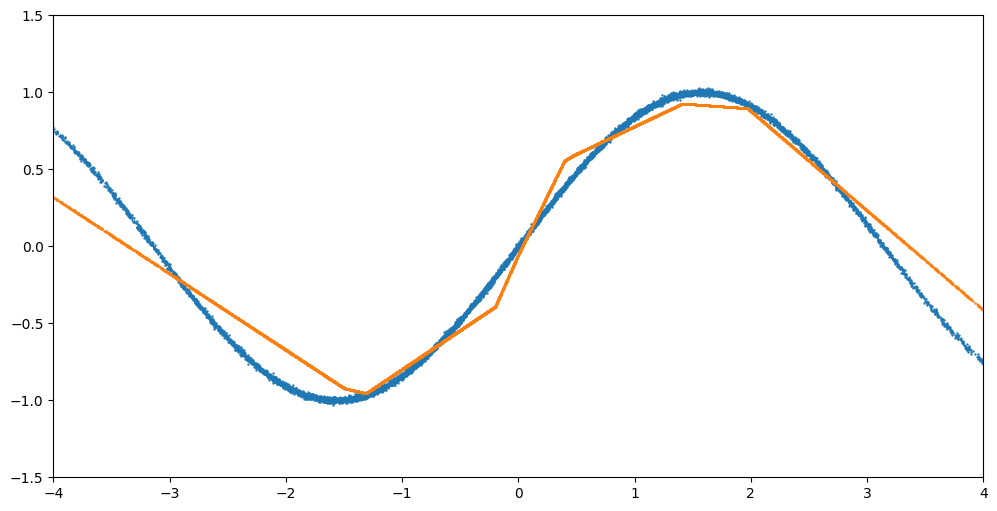

In [4]:
plot_one(X, y, y_preds)

In [5]:
plot(X, y, y_preds)